In [1]:
# Needed on Google Colab
import os
if os.environ.get('COLAB_GPU', False):
    !pip install -U transformers
    from google.colab import drive
    drive.mount("/content/drive")

     |████████████████████████████████| 2.3MB 5.4MB/s 
     |████████████████████████████████| 3.3MB 44.8MB/s 
     |████████████████████████████████| 901kB 54.3MB/s 
Mounted at /content/drive


In [2]:
import nltk
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

pd.options.display.max_colwidth = 6000
pd.options.display.max_rows = 400
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
print(tf.__version__)

2.5.0


In [3]:
COL_OPINION = 0
COL_SPEECH = 8
TOTAL_COLS = 14

RUNS = 21
BATCH_SIZE = 16
TEST_SPLIT = 0.15
VALIDATION_SPLIT = 0.15
SHUFFLE = True
STRATIFY = True
CLASS_WEIGHTS = True
REMOVE_STOP_WORDS = False
STEMMING = False
LOWERING = False
NO_PUNCTUATION = False

OUT_NAME = f'bert_01_{TEST_SPLIT}_{VALIDATION_SPLIT}_Shuff{SHUFFLE}_Strat{STRATIFY}_Weigh{CLASS_WEIGHTS}_NoStop{REMOVE_STOP_WORDS}_Stem{STEMMING}_Low{LOWERING}_NoPun{NO_PUNCTUATION}'
PATH_METRICS = f'results/{OUT_NAME}.csv'
PATH_DATASET = "datasets/massnahmen_relevant.csv"
PATH_PERFORMANCE_GRAPH = f'results/{OUT_NAME}.png'

Executing this on Colab will make sure that our model runs on a TPU if available and falls back to GPU / CPU otherwise:

In [4]:
# Try to run on TPU if available
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.47.170.202:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.47.170.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.47.170.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [5]:
# store current path and download and extract data there
CURR_PATH = !pwd

In [6]:
# PARAMETERS
PATH_DATA = CURR_PATH[0]
PATH_GDRIVE_TMP = "/content/drive/MyDrive/tmp/"  # Google Drive

In [7]:
# read data from csv
data = pd.read_csv(PATH_GDRIVE_TMP + PATH_DATASET, sep='\t', header=None, skiprows=[0])

data["opinion_integer"] = 0
data.loc[data[COL_OPINION] == '-', "opinion_integer"] = 0
data.loc[data[COL_OPINION] == 'o', "opinion_integer"] = 1
data.loc[data[COL_OPINION] == '+', "opinion_integer"] = 2

data.head(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,opinion_integer
0,+,False,172479,2021_02_24,85,ÖVP,Abgeordnete MMMag. Gertraud Salzmann (ÖVP),True,"Die Tourismusleistungen sind derartig gut, dass wir von Österreich aus gesehen europaweit führend sind, unter anderem auch bei den Tests, zum Beispiel bei den Tests in den Schulen.",False,False,False,True,False,2
1,-,False,174259,2021_02_24,85,ÖVP,Abgeordnete Gabriela Schwarz (ÖVP),True,"Da ist nämlich schon die Rede davon, ob sich jemand von euch überlegt hat, was es für andere bedeutet, Masken zu tragen: für Ärztinnen und Ärzte, die ewig im OP stehen und die selbstverständlich Masken tragen, für Pflegepersonal, das Masken trägt, für Apotheker, lieber Gerhard Kaniak – ich habe dich ersucht, in meiner Gegenwart eine FFP2-Maske zu tragen, du hast gesagt, vulnerablen Gruppen gegenüber machst du das, ich habe nicht aufs Hirn tätowiert, dass ich eine Risikopatientin bin; also so viel dazu –; diese Menschen tragen Masken.",True,False,False,False,False,0
2,+,True,174159,2021_02_24,85,Grüne,Abgeordneter Ralph Schallmeiner (Grüne),True,"Okay, zum einen gibt es den klassischen Antrag der FPÖ – in diesem Fall, dass man eben eine durchaus notwendige und anerkannte Maßnahme wieder abschaffen möchte, nämlich das Maskentragen. Überall dort, wo wir eng zusammenkommen, sollen die Masken fallen, nach diesem Prinzip – obwohl eigentlich in der Zwischenzeit schon genügend Evidenzen da sind, dass die Maske durchaus sinnvoll ist, dass sie uns schützt, dass wir damit andere schützen, dass es nebst anderen Maßnahmen auch damit zu einer Eindämmung der Pandemie kommen kann. Deswegen werden wir diesen Antrag natürlich ablehnen beziehungsweise haben wir ihn auch im Gesundheitsausschuss abgelehnt.",True,False,False,False,False,2
3,-,True,63480,2020_05_26,32,FPÖ,Abgeordneter Peter Wurm (FPÖ),False,"Ich hoffe, es folgen Ihnen möglichst bald alle Ihre Regierungskollegen. Sie sind ja ohne Maske ein wesentlich angenehmerer Anblick als mit Maske. – Das darf ich noch anfügen.",True,False,False,False,False,0
4,+,False,196099,2021_04_21,97,ÖVP,"Bundesminister für Inneres Karl Nehammer, MSc",True,"– Am besten beweisen die Demonstrationen, dass der, der eine rot-weiß-rote Fahne trägt, noch lange kein Patriot ist , denn Patriotismus ist die Liebe zu den Seinen, und die Liebe zu den Seinen heißt, die Schutzmaßnahmen zu befolgen, auf den Abstand zu achten, die Schutzmaske zu tragen.",True,False,False,False,True,2
5,o,True,172737,2021_02_24,85,ÖVP,"Bundesminister für Bildung, Wissenschaft und Forschung Dr. Heinz Faßmann",True,"Geschätzte Mitglieder des Nationalrates! Ich danke Ihnen, Herr Abgeordneter Brückl, für die Thematisierung der Anfragebeantwortung zum Thema Rechtsgrundlage der Maskenpflicht, auf die ich gleich zu sprechen kommen werde. Ich denke, uns verbindet über alle Parteigrenzen hinweg die Sorge um eine funktionierende Schule in der Pandemie.",True,False,False,False,False,1


In [8]:
nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))


def clean_text(text):
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    if NO_PUNCTUATION:
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    else:
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    tokenizer = nltk.RegexpTokenizer(r"\w+")
    word_tokens = tokenizer.tokenize(text)
    if LOWERING:
        word_tokens = [word.lower() for word in word_tokens]
    else:
        word_tokens = [word for word in word_tokens]

    if REMOVE_STOP_WORDS:
        word_tokens = [word for word in word_tokens if word not in stop_words]

    if STEMMING:
        word_tokens = [stemmer.stem(word) for word in word_tokens]

    return ' '.join(word_tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
%%time
# Clean Comments
data["comment_clean"] = data.loc[data[COL_SPEECH].str.len() > 1, COL_SPEECH]
data["comment_clean"] = data["comment_clean"].map(
    lambda x: clean_text(x) if isinstance(x, str) else x
)

CPU times: user 335 ms, sys: 11.7 ms, total: 347 ms
Wall time: 357 ms


In [10]:
# Drop Missing
data = data.dropna(axis="index", subset=["opinion_integer", "comment_clean"]).reset_index(
    drop=True
)
data.rename(columns={'opinion_integer': 'label', 'comment_clean': 'text'}, inplace=True)
#data = data[["comment_clean", "opinion_integer"]]
#data.columns = ["text", "label"]

In [11]:
# this will download and initialize the pre trained tokenizer
from transformers import BertTokenizer, TFBertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")

In [12]:
MAXLEN = 128

def preprocess_text(data):
    """ take texts and prepare as input features for BERT 
    """
    input_ids = []
    # For every sentence...
    for comment in data:
        encoded_sent = tokenizer.encode_plus(
            text=comment,
            add_special_tokens=True,  # Add `[CLS]` and `[SEP]`
            max_length=MAXLEN,  # Max length to truncate/pad
            pad_to_max_length=True,  # Pad sentence to max length
            return_attention_mask=False,  # attention mask not needed for our task
        )
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get("input_ids"))
    return input_ids

In [13]:
input_ids = preprocess_text(data["text"])
data['input_ids'] = input_ids

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


# Here Begins the Repeatable Code

In [14]:
# Set Model Parameters
MAXLEN = MAXLEN
BATCH_SIZE_PER_REPLICA = 8
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
EPOCHS = 20
LEARNING_RATE = 1e-5
DATA_LENGTH = len(data)

In [15]:
# Stop training when validation acc starts dropping
# Save checkpoint of model each period
now = datetime.now().strftime("%Y-%m-%d_%H%M")
# Create callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", verbose=1, patience=5, restore_best_weights=True
    ),
    # tf.keras.callbacks.ModelCheckpoint(
    #    PATH_GDRIVE_TMP + now + "_Model_{epoch:02d}_{val_loss:.4f}.h5",
    #    monitor="val_loss",
    #    save_best_only=True,
    #    verbose=1,
    # ),
]

In [16]:
def build_model(transformer, max_len=MAXLEN):
    """ add binary classification to pretrained model
    """
    input_word_ids = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="input_word_ids"
    )
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = tf.keras.layers.Dense(3, activation="sigmoid")(cls_token)
    model = tf.keras.models.Model(inputs=input_word_ids, outputs=out)
    model.compile(
        tf.keras.optimizers.Adam(lr=LEARNING_RATE),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [17]:
def create_dataset(
    data_tuple,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    buffer_size=DATA_LENGTH,
    train=False,
):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(
            buffer_size=buffer_size, reshuffle_each_iteration=True
        ).repeat(epochs)
    dataset = dataset.batch(batch_size)
    return dataset

In [18]:
from collections import Counter

In [19]:
from sklearn.model_selection import StratifiedKFold

In [20]:
skf = StratifiedKFold(n_splits=10, shuffle=True)
i = 0
for train_index, test_index in skf.split(np.zeros(len(y)), data['label']):
  
  #train_ids_, test_ids, train_labels_, test_labels = train_test_split(input_ids, data["label"], test_size=TEST_SPLIT, shuffle=SHUFFLE, stratify=data["label"])

  train_ids_ = data.loc[train_index,'input_ids']
  train_labels_ = data.loc[train_index,'label']
  train_ids, valid_ids, train_labels, valid_labels = train_test_split(train_ids_, train_labels_, test_size=VALIDATION_SPLIT, shuffle=SHUFFLE, stratify=train_labels_)

  train = create_dataset( ( list(train_ids), train_labels ), buffer_size=len(train_ids), train=True)
  validation = create_dataset((list(valid_ids), valid_labels), buffer_size=len(valid_ids), train=True)

  test_ids = data.loc[test_index, 'input_ids']
  test_labels = data.loc[test_index, 'label']
  test = create_dataset((list(test_ids), test_labels), buffer_size=len(test_ids))
  
  with strategy.scope():
    transformer_layers = TFBertModel.from_pretrained("bert-base-german-cased")
    model = build_model(transformer_layers, max_len=MAXLEN)
  train_counts = Counter(train_labels)
  num_in_largest_class = max(train_counts.values())
  class_weights = {k: num_in_largest_class / train_counts[k] for k in train_counts.keys()}

  # Train using appropriate steps per epochs (go through all train data in an epoch)
  steps_per_epoch = int(np.floor((len(train_ids) / BATCH_SIZE)))
  hist = model.fit(
    train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation,
    verbose=1,
    class_weight = class_weights if CLASS_WEIGHTS else None,
    callbacks=callbacks,
  )

  # Evaluate
  pred = model.predict(test, batch_size=BATCH_SIZE, verbose=2, use_multiprocessing=True)
  pred_class = np.argmax(pred, axis=-1)
  data.loc[test_index, 'prediction'] = pred_class
  data.loc[test_index,[2,'label','prediction']].to_csv(PATH_GDRIVE_TMP + f'results/bert_predictions_{i}.csv', sep='\t')
  i += 1


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


61/61 [==============================] - ETA: 0s - loss: 1.7103 - accuracy: 0.4408

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


61/61 [==============================] - 97s 386ms/step - loss: 1.7103 - accuracy: 0.4408 - val_loss: 0.9564 - val_accuracy: 0.5072
Epoch 2/20
61/61 [==============================] - 11s 177ms/step - loss: 1.3417 - accuracy: 0.6040 - val_loss: 0.7736 - val_accuracy: 0.6609
Epoch 3/20
61/61 [==============================] - 11s 177ms/step - loss: 1.1089 - accuracy: 0.6911 - val_loss: 0.7176 - val_accuracy: 0.6913
Epoch 4/20
61/61 [==============================] - 11s 176ms/step - loss: 0.8963 - accuracy: 0.7561 - val_loss: 0.6910 - val_accuracy: 0.7116
Epoch 5/20
61/61 [==============================] - 11s 184ms/step - loss: 0.7026 - accuracy: 0.8207 - val_loss: 0.7235 - val_accuracy: 0.7145
Epoch 6/20
61/61 [==============================] - 11s 177ms/step - loss: 0.5161 - accuracy: 0.8601 - val_loss: 0.7718 - val_accuracy: 0.7087
Epoch 7/20
61/61 [==============================] - 11s 177ms/step - loss: 0.3774 - accuracy: 0.9037 - val_loss: 0.8696 - val_accuracy: 0.7217
Epoch 8/20

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


8/8 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


61/61 [==============================] - ETA: 0s - loss: 1.7059 - accuracy: 0.4541

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


61/61 [==============================] - 101s 391ms/step - loss: 1.7059 - accuracy: 0.4541 - val_loss: 0.9083 - val_accuracy: 0.5652
Epoch 2/20
61/61 [==============================] - 11s 177ms/step - loss: 1.3350 - accuracy: 0.6209 - val_loss: 0.7132 - val_accuracy: 0.6797
Epoch 3/20
61/61 [==============================] - 11s 178ms/step - loss: 1.0656 - accuracy: 0.7100 - val_loss: 0.6990 - val_accuracy: 0.7058
Epoch 4/20
61/61 [==============================] - 11s 178ms/step - loss: 0.8415 - accuracy: 0.7707 - val_loss: 0.7209 - val_accuracy: 0.6971
Epoch 5/20
61/61 [==============================] - 11s 178ms/step - loss: 0.6723 - accuracy: 0.8204 - val_loss: 0.7460 - val_accuracy: 0.7087
Epoch 6/20
61/61 [==============================] - 11s 178ms/step - loss: 0.4593 - accuracy: 0.8873 - val_loss: 0.7869 - val_accuracy: 0.7174
Epoch 7/20
61/61 [==============================] - 11s 177ms/step - loss: 0.3352 - accuracy: 0.9188 - val_loss: 0.8286 - val_accuracy: 0.7217
Epoch 8/2

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


8/8 - 9s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


61/61 [==============================] - ETA: 0s - loss: 1.6406 - accuracy: 0.4687

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


61/61 [==============================] - 100s 391ms/step - loss: 1.6406 - accuracy: 0.4687 - val_loss: 0.7969 - val_accuracy: 0.6536
Epoch 2/20
61/61 [==============================] - 11s 177ms/step - loss: 1.2547 - accuracy: 0.6473 - val_loss: 0.7044 - val_accuracy: 0.7043
Epoch 3/20
61/61 [==============================] - 11s 177ms/step - loss: 1.0450 - accuracy: 0.7218 - val_loss: 0.7557 - val_accuracy: 0.6971
Epoch 4/20
61/61 [==============================] - 11s 178ms/step - loss: 0.8567 - accuracy: 0.7738 - val_loss: 0.7224 - val_accuracy: 0.7116
Epoch 5/20
61/61 [==============================] - 11s 189ms/step - loss: 0.6359 - accuracy: 0.8356 - val_loss: 0.8049 - val_accuracy: 0.7058
Epoch 6/20
61/61 [==============================] - 11s 178ms/step - loss: 0.4510 - accuracy: 0.8824 - val_loss: 0.7977 - val_accuracy: 0.7290
Epoch 7/20
61/61 [==============================] - 11s 177ms/step - loss: 0.3085 - accuracy: 0.9226 - val_loss: 0.9013 - val_accuracy: 0.7174
Restoring

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


8/8 - 10s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


61/61 [==============================] - ETA: 0s - loss: 1.7289 - accuracy: 0.4301

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


61/61 [==============================] - 102s 390ms/step - loss: 1.7289 - accuracy: 0.4301 - val_loss: 0.9153 - val_accuracy: 0.5812
Epoch 2/20
61/61 [==============================] - 11s 176ms/step - loss: 1.3896 - accuracy: 0.6012 - val_loss: 0.8209 - val_accuracy: 0.6304
Epoch 3/20
61/61 [==============================] - 11s 187ms/step - loss: 1.0990 - accuracy: 0.6962 - val_loss: 0.6965 - val_accuracy: 0.6957
Epoch 4/20
61/61 [==============================] - 11s 177ms/step - loss: 0.9093 - accuracy: 0.7490 - val_loss: 0.6876 - val_accuracy: 0.6928
Epoch 5/20
61/61 [==============================] - 11s 177ms/step - loss: 0.7026 - accuracy: 0.8120 - val_loss: 0.7365 - val_accuracy: 0.6913
Epoch 6/20
61/61 [==============================] - 11s 177ms/step - loss: 0.5334 - accuracy: 0.8543 - val_loss: 0.7688 - val_accuracy: 0.7116
Epoch 7/20
61/61 [==============================] - 11s 177ms/step - loss: 0.3786 - accuracy: 0.9004 - val_loss: 0.7850 - val_accuracy: 0.7116
Epoch 8/2

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


8/8 - 10s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


61/61 [==============================] - ETA: 0s - loss: 1.7279 - accuracy: 0.4403

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


61/61 [==============================] - 103s 404ms/step - loss: 1.7279 - accuracy: 0.4403 - val_loss: 0.8904 - val_accuracy: 0.5594
Epoch 2/20
61/61 [==============================] - 11s 177ms/step - loss: 1.4157 - accuracy: 0.5943 - val_loss: 0.7140 - val_accuracy: 0.6826
Epoch 3/20
61/61 [==============================] - 11s 178ms/step - loss: 1.1502 - accuracy: 0.6895 - val_loss: 0.7628 - val_accuracy: 0.6362
Epoch 4/20
61/61 [==============================] - 11s 178ms/step - loss: 0.9352 - accuracy: 0.7449 - val_loss: 0.7026 - val_accuracy: 0.7116
Epoch 5/20
61/61 [==============================] - 11s 178ms/step - loss: 0.7102 - accuracy: 0.8102 - val_loss: 0.7161 - val_accuracy: 0.6986
Epoch 6/20
61/61 [==============================] - 11s 180ms/step - loss: 0.5300 - accuracy: 0.8624 - val_loss: 0.7749 - val_accuracy: 0.7058
Epoch 7/20
61/61 [==============================] - 11s 179ms/step - loss: 0.3698 - accuracy: 0.9057 - val_loss: 0.8242 - val_accuracy: 0.6957
Epoch 8/2

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


8/8 - 10s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


61/61 [==============================] - ETA: 0s - loss: 1.6959 - accuracy: 0.4649

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


61/61 [==============================] - 104s 396ms/step - loss: 1.6959 - accuracy: 0.4649 - val_loss: 0.8512 - val_accuracy: 0.6087
Epoch 2/20
61/61 [==============================] - 11s 178ms/step - loss: 1.3358 - accuracy: 0.6206 - val_loss: 0.7135 - val_accuracy: 0.6710
Epoch 3/20
61/61 [==============================] - 11s 178ms/step - loss: 1.0878 - accuracy: 0.6977 - val_loss: 0.6984 - val_accuracy: 0.6942
Epoch 4/20
61/61 [==============================] - 11s 179ms/step - loss: 0.8572 - accuracy: 0.7710 - val_loss: 0.6189 - val_accuracy: 0.7362
Epoch 5/20
61/61 [==============================] - 11s 179ms/step - loss: 0.6870 - accuracy: 0.8207 - val_loss: 0.6672 - val_accuracy: 0.7188
Epoch 6/20
61/61 [==============================] - 11s 179ms/step - loss: 0.4902 - accuracy: 0.8755 - val_loss: 0.6794 - val_accuracy: 0.7348
Epoch 7/20
61/61 [==============================] - 11s 180ms/step - loss: 0.3240 - accuracy: 0.9191 - val_loss: 0.7823 - val_accuracy: 0.7435
Epoch 8/2

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


8/8 - 10s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


61/61 [==============================] - ETA: 0s - loss: 1.6135 - accuracy: 0.4956

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


61/61 [==============================] - 103s 395ms/step - loss: 1.6135 - accuracy: 0.4956 - val_loss: 0.8229 - val_accuracy: 0.6087
Epoch 2/20
61/61 [==============================] - 11s 177ms/step - loss: 1.2617 - accuracy: 0.6455 - val_loss: 0.8243 - val_accuracy: 0.6246
Epoch 3/20
61/61 [==============================] - 11s 178ms/step - loss: 1.0513 - accuracy: 0.7162 - val_loss: 0.6964 - val_accuracy: 0.7000
Epoch 4/20
61/61 [==============================] - 11s 178ms/step - loss: 0.8317 - accuracy: 0.7779 - val_loss: 0.7241 - val_accuracy: 0.6913
Epoch 5/20
61/61 [==============================] - 11s 177ms/step - loss: 0.6171 - accuracy: 0.8402 - val_loss: 0.8042 - val_accuracy: 0.6928
Epoch 6/20
61/61 [==============================] - 11s 178ms/step - loss: 0.4348 - accuracy: 0.8940 - val_loss: 0.8161 - val_accuracy: 0.7116
Epoch 7/20
61/61 [==============================] - 11s 177ms/step - loss: 0.3032 - accuracy: 0.9244 - val_loss: 0.8634 - val_accuracy: 0.6913
Epoch 8/2

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


8/8 - 12s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


61/61 [==============================] - ETA: 0s - loss: 1.6783 - accuracy: 0.4618

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


61/61 [==============================] - 101s 398ms/step - loss: 1.6783 - accuracy: 0.4618 - val_loss: 0.8543 - val_accuracy: 0.5754
Epoch 2/20
61/61 [==============================] - 11s 177ms/step - loss: 1.3299 - accuracy: 0.6224 - val_loss: 0.7517 - val_accuracy: 0.6522
Epoch 3/20
61/61 [==============================] - 11s 177ms/step - loss: 1.0877 - accuracy: 0.7093 - val_loss: 0.6690 - val_accuracy: 0.6986
Epoch 4/20
61/61 [==============================] - 11s 179ms/step - loss: 0.8736 - accuracy: 0.7574 - val_loss: 0.6652 - val_accuracy: 0.7072
Epoch 5/20
61/61 [==============================] - 11s 178ms/step - loss: 0.6943 - accuracy: 0.8135 - val_loss: 0.6733 - val_accuracy: 0.7174
Epoch 6/20
61/61 [==============================] - 11s 178ms/step - loss: 0.5133 - accuracy: 0.8591 - val_loss: 0.7347 - val_accuracy: 0.7362
Epoch 7/20
61/61 [==============================] - 11s 179ms/step - loss: 0.3552 - accuracy: 0.9098 - val_loss: 0.7710 - val_accuracy: 0.7130
Epoch 8/2

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


8/8 - 10s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


61/61 [==============================] - ETA: 0s - loss: 1.6887 - accuracy: 0.4385

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


61/61 [==============================] - 103s 397ms/step - loss: 1.6887 - accuracy: 0.4385 - val_loss: 0.9173 - val_accuracy: 0.5609
Epoch 2/20
61/61 [==============================] - 11s 179ms/step - loss: 1.3206 - accuracy: 0.6260 - val_loss: 0.8116 - val_accuracy: 0.6478
Epoch 3/20
61/61 [==============================] - 11s 178ms/step - loss: 1.1016 - accuracy: 0.6983 - val_loss: 0.8526 - val_accuracy: 0.6464
Epoch 4/20
61/61 [==============================] - 11s 181ms/step - loss: 0.8592 - accuracy: 0.7677 - val_loss: 0.7195 - val_accuracy: 0.6986
Epoch 5/20
61/61 [==============================] - 11s 180ms/step - loss: 0.6738 - accuracy: 0.8210 - val_loss: 0.7438 - val_accuracy: 0.6884
Epoch 6/20
61/61 [==============================] - 11s 179ms/step - loss: 0.4847 - accuracy: 0.8737 - val_loss: 0.8135 - val_accuracy: 0.7000
Epoch 7/20
61/61 [==============================] - 11s 178ms/step - loss: 0.3366 - accuracy: 0.9150 - val_loss: 0.8043 - val_accuracy: 0.7188
Epoch 8/2

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


8/8 - 10s


Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=float32>]


61/61 [==============================] - ETA: 0s - loss: 1.7054 - accuracy: 0.4401

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


61/61 [==============================] - 104s 397ms/step - loss: 1.7054 - accuracy: 0.4401 - val_loss: 0.8691 - val_accuracy: 0.5826
Epoch 2/20
61/61 [==============================] - 11s 176ms/step - loss: 1.3851 - accuracy: 0.6022 - val_loss: 0.8113 - val_accuracy: 0.6348
Epoch 3/20
61/61 [==============================] - 11s 177ms/step - loss: 1.1362 - accuracy: 0.6806 - val_loss: 0.6864 - val_accuracy: 0.7000
Epoch 4/20
61/61 [==============================] - 11s 177ms/step - loss: 0.9556 - accuracy: 0.7400 - val_loss: 0.6977 - val_accuracy: 0.7014
Epoch 5/20
61/61 [==============================] - 11s 190ms/step - loss: 0.7426 - accuracy: 0.7987 - val_loss: 0.7389 - val_accuracy: 0.6986
Epoch 6/20
61/61 [==============================] - 11s 180ms/step - loss: 0.5484 - accuracy: 0.8540 - val_loss: 0.7252 - val_accuracy: 0.7174
Epoch 7/20
61/61 [==============================] - 11s 180ms/step - loss: 0.3708 - accuracy: 0.9144 - val_loss: 0.8331 - val_accuracy: 0.7261
Epoch 8/2

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 128) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


8/8 - 10s


In [ ]:
len(test_index)

511

# New Section

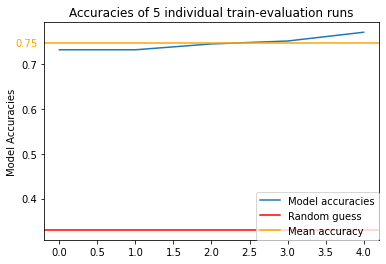

In [ ]:
total = len(accuracies)
mean = sum(accuracies)/total

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sorted(accuracies), label='Model accuracies')
plt.axhline(y=0.33, color='r', linestyle='-', label='Random guess')
plt.axhline(y=mean, color='orange', linestyle='-', label='Mean accuracy')
ax.text(-0.02, mean, "{:.2f}".format(mean), color='orange', ha="right", va="center", 
        transform=ax.get_yaxis_transform())
plt.ylabel('Model Accuracies')
plt.title(f"Accuracies of {total} individual train-evaluation runs")
plt.legend(loc="lower right", borderaxespad=0)
plt.savefig(PATH_GDRIVE_TMP + PATH_PERFORMANCE_GRAPH)
plt.show()